In [1200]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_theme(rc={'figure.dpi': 72, 'savefig.dpi': 300,
              'figure.autolayout': True})
sns.set_style('ticks')
sns.set_context('paper')

In [1201]:
# Load the dataset.
df = pd.read_csv('data/lungcancer.csv')
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Preprocess
X['GENDER'] = X['GENDER'] == 'M'
y = y == 'YES'

for c in X.columns:
    if c == 'GENDER' or c == 'AGE':
        continue
    X[c] = X[c] == 2

l = 10
s = X['AGE'].min()
e = X['AGE'].max()
labels = ["{0}-{1}".format(i, i + l) for i in range(s, e, l)]
X['age_group'] = pd.cut(X['AGE'], range(s, e + l, l), right=False, labels=labels)
X = X.drop(columns=['AGE'])

In [1202]:
import math


class Decision:
    def __init__(self,
                 feature,
                 value,
                 true_child=None,
                 false_child=None,
                 level=0,
                 id=0,
                 data=None):
        self.feature = feature
        self.value = value
        self.true_child = true_child
        self.false_child = false_child
        self.level = level
        self.id = id
        self.data = data

    def match(self, x):
        val = x[self.feature]
        if isinstance(val, int) or isinstance(val, float):
            return val >= self.value
        else:
            return val == self.value


class Leaf:
    def __init__(self, data, id, level, lcnt, label):
        self.labels_count = lcnt
        self.label = label
        self.id = id
        self.level = level


class DecisionTree:
    def __init__(self, max_depth=0):
        self.max_depth = max_depth
        self.tree = None

    def learn(self, X, y):
        self.tree = self._build_tree(np.c_[X, y].tolist())
        self._depth_prune()

    def predict(self, X):
        preds = []
        for x in X:
            pred = self._predict(x, self.tree)
            preds.append(pred)
        return np.array(preds)

    def get_n_leaves(self):
        return len(self._get_leaves(self.tree))

    def get_n_nodes(self):
        inners = self._get_inners(self.tree)
        return self.get_n_leaves() + len(inners)

    def get_depth(self):
        leaves = self._get_leaves(self.tree)
        maxd = 0
        for leaf in leaves:
            if leaf.level > maxd:
                maxd = leaf.level
        return maxd

    def _predict(self, X, node):
        if isinstance(node, Leaf):
            return node.label
        if node.match(X):
            return self._predict(X, node.true_child)
        else:
            return self._predict(X, node.false_child)

    def _build_tree(self, data, level=0, id=0):
        gain, decision = self._find_best_split(data)
        if gain == 0:
            lcnt = self._count_labels(data)
            label = self._max_label(lcnt)
            return Leaf(data, id, level, lcnt, label)
        true_d, false_d = self._partition(data, decision)
        decision.true_child = self._build_tree(true_d, level + 1, 2 * id + 2)
        decision.false_child = self._build_tree(false_d, level + 1, 2 * id + 1)
        decision.level = level
        decision.id = id
        decision.data = data
        return decision

    def _partition(self, data, decision):
        true_d, false_d = [], []
        for d in data:
            if decision.match(d):
                true_d.append(d)
            else:
                false_d.append(d)
        return true_d, false_d

    def _find_best_split(self, data):
        best_gain = 0
        best_split = None
        current_entropy = self._entropy(data)
        n_features = len(data[0]) - 1
        for col in range(n_features):
            values = set([d[col] for d in data])
            for val in values:
                decision = Decision(col, val)
                true_d, false_d = self._partition(data, decision)
                if len(true_d) == 0 or len(false_d) == 0:
                    continue
                gain = self._info_gain(true_d, false_d, current_entropy)
                if gain >= best_gain:
                    best_gain, best_split = gain, decision
        return best_gain, best_split

    def _entropy(self, data):
        entries = self._count_labels(data)
        avg_entropy = 0
        for label in entries:
            prob = entries[label] / len(data)
            avg_entropy = -(avg_entropy + (prob * math.log(prob, 2)))
        return avg_entropy

    def _info_gain(self, td, fd, cur_ent):
        p = len(td) / (len(td) + len(fd))
        return cur_ent - p * self._entropy(td) - (1 - p) * self._entropy(fd)

    def _get_leaves(self, node):
        if isinstance(node, Leaf):
            return [node]
        t = self._get_leaves(node.true_child)
        f = self._get_leaves(node.false_child)
        return t + f

    def _get_inners(self, node):
        if isinstance(node, Leaf):
            return []
        t = self._get_inners(node.true_child)
        f = self._get_inners(node.false_child)
        return [node] + t + f

    def _prune(self, node, pruned):
        if isinstance(node, Leaf):
            return node
        if node.id in pruned:
            lcnt = self._count_labels(node.data)
            label = self._max_label(lcnt)
            return Leaf(node.data, node.id, node.level, lcnt, label)
        node.true_child = self._prune(node.true_child, pruned)
        node.false_child = self._prune(node.false_child, pruned)
        return node

    def _depth_prune(self):
        if self.max_depth < 1:
            return
        inners = self._get_inners(self.tree)
        for inner in inners:
            if inner.level >= self.max_depth:
                self._prune(self.tree, [inner.id])

    def _max_label(self, lcnt):
        maxcnt = 0
        label = ''
        for key, value in lcnt.items():
            if lcnt[key] > maxcnt:
                maxcnt = lcnt[key]
                label = key
        return label

    def _count_labels(self, data):
        cnt = {}
        for d in data:
            label = d[-1]
            if label not in cnt:
                cnt[label] = 0
            cnt[label] += 1
        return cnt


In [1203]:

def split_data(X, y, train_size):
    p = np.random.permutation(len(y))
    X, y = X[p], y[p]
    trlen = int(train_size * len(y))
    X_train = X[:trlen]
    X_test = X[trlen:]
    y_train = y[:trlen]
    y_test = y[trlen:]
    return X_train, X_test, y_train, y_test


def confusion_matrix(y_true, y_pred, labels):
    m = np.zeros((labels.shape[0], labels.shape[0]), dtype=int)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            m[i, j] = np.sum((y_true == labels[i]) & (y_pred == labels[j]))
    return m


def accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)


def eval(iterations, train_splits):
    for ts in train_splits:
        scores = []
        for it in range(iterations):
            print(f'Results for iteration {it + 1} with train size {ts*100:.0f}%:')
            X_train, X_test, y_train, y_test = split_data(X.values, y.values, ts)
            dt = DecisionTree()
            dt.learn(X_train, y_train)
            y_pred = dt.predict(X_test)
            labels = np.sort(np.unique(y_test))
            acc = accuracy(y_test, y_pred)
            scores.append(acc)
            print('Accuracy:', round(acc, 4))
            print('Confusion Matrix:')
            print(confusion_matrix(y_test, y_pred, labels))
            print('Depth:', dt.get_depth())
            print('Number of nodes:', dt.get_n_nodes())
            print('Number of leaves:', dt.get_n_leaves())
            print()
        if iterations > 1:
            m = round(np.mean(scores), 4)
            s = round(np.std(scores), 4)
            print(f'Average accuracy of {iterations} iterations with train size {ts*100:.0f}%: {m} ± {s}')
            print('\n')

In [1204]:
# Part a
eval(1, [0.25])

Results for iteration 1 with train size 25%:
Accuracy: 0.8578
Confusion Matrix:
[[ 12  19]
 [ 14 187]]
Depth: 5
Number of nodes: 15
Number of leaves: 8



In [1205]:
# Part b
eval(7, [0.25])

Results for iteration 1 with train size 25%:
Accuracy: 0.875
Confusion Matrix:
[[  0  29]
 [  0 203]]
Depth: 4
Number of nodes: 9
Number of leaves: 5

Results for iteration 2 with train size 25%:
Accuracy: 0.8793
Confusion Matrix:
[[  0  28]
 [  0 204]]
Depth: 4
Number of nodes: 9
Number of leaves: 5

Results for iteration 3 with train size 25%:
Accuracy: 0.8707
Confusion Matrix:
[[  0  29]
 [  1 202]]
Depth: 2
Number of nodes: 5
Number of leaves: 3

Results for iteration 4 with train size 25%:
Accuracy: 0.8793
Confusion Matrix:
[[  0  28]
 [  0 204]]
Depth: 0
Number of nodes: 1
Number of leaves: 1

Results for iteration 5 with train size 25%:
Accuracy: 0.8534
Confusion Matrix:
[[ 13  15]
 [ 19 185]]
Depth: 4
Number of nodes: 11
Number of leaves: 6

Results for iteration 6 with train size 25%:
Accuracy: 0.7716
Confusion Matrix:
[[ 18  13]
 [ 40 161]]
Depth: 4
Number of nodes: 9
Number of leaves: 5

Results for iteration 7 with train size 25%:
Accuracy: 0.8664
Confusion Matrix:
[[  3  2

In [1206]:
# Part c
eval(7, [0.45, 0.65, 0.85])

Results for iteration 1 with train size 45%:
Accuracy: 0.8706
Confusion Matrix:
[[  1  20]
 [  2 147]]
Depth: 5
Number of nodes: 13
Number of leaves: 7

Results for iteration 2 with train size 45%:
Accuracy: 0.8647
Confusion Matrix:
[[  9  13]
 [ 10 138]]
Depth: 5
Number of nodes: 17
Number of leaves: 9

Results for iteration 3 with train size 45%:
Accuracy: 0.8588
Confusion Matrix:
[[  4  18]
 [  6 142]]
Depth: 5
Number of nodes: 11
Number of leaves: 6

Results for iteration 4 with train size 45%:
Accuracy: 0.8588
Confusion Matrix:
[[  0  22]
 [  2 146]]
Depth: 5
Number of nodes: 17
Number of leaves: 9

Results for iteration 5 with train size 45%:
Accuracy: 0.8294
Confusion Matrix:
[[ 14   7]
 [ 22 127]]
Depth: 5
Number of nodes: 21
Number of leaves: 11

Results for iteration 6 with train size 45%:
Accuracy: 0.8824
Confusion Matrix:
[[ 12   7]
 [ 13 138]]
Depth: 6
Number of nodes: 23
Number of leaves: 12

Results for iteration 7 with train size 45%:
Accuracy: 0.8176
Confusion Matrix:


Optimal max depth for Train set: 5
Optimal max depth for Test set: 4
Maximum accuracy for Train set: 0.9004
Maximum accuracy for Test set: 0.8718


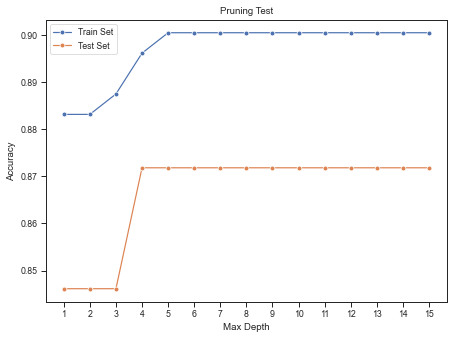

In [1207]:
# Part d
max_depths = list(range(1, 16))
train_scores = []
test_scores = []

X_train, X_test, y_train, y_test = split_data(X.values, y.values, 0.75)

for md in max_depths:
    dt = DecisionTree(max_depth=md)
    dt.learn(X_train, y_train)
    train_scores.append(accuracy(y_train, dt.predict(X_train)))
    test_scores.append(accuracy(y_test, dt.predict(X_test)))

print('Optimal max depth for Train set:', max_depths[np.argmax(train_scores)])
print('Optimal max depth for Test set:', max_depths[np.argmax(test_scores)])
print('Maximum accuracy for Train set:', round(max(train_scores), 4))
print('Maximum accuracy for Test set:', round(max(test_scores), 4))

fig, ax = plt.subplots()
sns.lineplot(x=max_depths, y=train_scores, label='Train Set', marker='o', ax=ax)
sns.lineplot(x=max_depths, y=test_scores, label='Test Set', marker='o', ax=ax)
ax.set(
    title='Pruning Test',
    xlabel='Max Depth',
    ylabel='Accuracy',
    xticks=max_depths,
)
fig.savefig('P3_d.png')
plt.show()
